#### ELEC-E8740 Basics of Sensor Fusion <br>
#### Homework 11<br>
#### Hoang Nguyen Khac 533263

### a) Simulate state and measurements from the model for 100 time steps. Plot the data.
Given a 1D non-linear model
$$
x_k = tanh(x_{k-1}) + q_{k-1}
$$
$$
y_k = sin(x_k) + r_k
$$
and 
$$
x_0 \sim N(0,1), q_{k-1} \sim N(0,0.1^2), r_k \sim N(0,0.1^2) 
$$


In [34]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.auto import tqdm 

[-0.67124461]


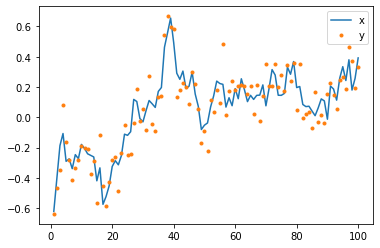

In [35]:
def f(x):
    return np.array([np.tanh(x)])

def g_fun(x):
    return np.array([np.sin(x)])

Q = 0.1**2

R = 0.1**2

steps = 100
m0 = 0  # Suitable initial mean
P0 = 1 # Suitable initial covariance

T = np.zeros((steps,))
X = np.zeros((steps,1))
Y = np.zeros((steps,1))
q = np.zeros(steps)

x = np.random.normal(m0,P0,1)
print(x)
t = 0

for n in range(steps):
    q[n] = np.random.normal(0,np.sqrt(Q),1)
    x = f(x) + q[n]
    r = np.random.normal(0,np.sqrt(R),1)
    y = g_fun(x) + r
    t = t + 1
    T[n] = t
    X[n] = x
    Y[n] = y

plt.clf()
plt.plot(T,X,T,Y,'.')
plt.legend(['x','y'])



### b) Implement and run a particle ﬁlter on the model. Plot the results and compute the RMSE of the particle ﬁlter when the estimated state mean is used as the estimator.

In [36]:
T = 50
def f(x):
    return np.array([np.tanh(x)])

def g_fun(x):
    return np.array([np.sin(x)])

def simulate_lgssm(T: int):
    """T is the number of observations"""
    
    # create the arrays
    xs = np.empty((T + 1,))
    ys = np.empty((T,))

    # inital state
    x = np.random.normal(0,1)
    xs[0] = x

    # loop over the propagation-emission loop
    for i in range(T):
        x = f(x) + np.random.normal(0,0.1)
        y = g_fun(x) + np.random.normal(0,0.1)
        xs[i+1] = x
        ys[i] = y

    return xs, ys
def pf(ys, N, fast_multinomial=False):
    # This algorithm sadly happens to have complexity $O(N \log(N))$, 
    # the main bottleneck being how to resample indices. While solutions exist
    # We kept it this way for ease of illustration. You may trigger a faster
    # behaviour by calling it with fast_multinomial=True instead, 
    # however the searchsorted still has $O(N \log(N))$ complexity

    def predict(x, eps):
        return x + eps  # simply propagate

    def update(x, y):
        w = stats.norm.pdf(x - y)  # compute your observation weights
        W = w / w.sum()  # normalise

        if not fast_multinomial:
        # sample ancestor indices based on W (multinomial is used here)
        # the below reads as "sample N (second argument) elements 
        # from {0, ..., N-1} (first argument) where P(A[i] = j) = W_j (p=W argument)"
            A = np.random.choice(N, N, p=W)
        else:
            vs = np.random.rand(N+1)
            us = np.log(vs[1:] / vs[:-1])  # pre sorted uniforms
            cumsum = np.cumsum(W)
            A = np.searchsorted(cumsum, us)
            

        return x[A]  # just apply the resampling index
        
    particles = np.empty((T+1, N))

    # initial state
    particles[0] = x = np.random.randn(N)
    epsilons = np.random.randn(T+1, N)  # pregenerate the Gaussians we will need

    # one prediction step
    x = predict(x, epsilons[0])

    for i in range(T):
        particles[i+1] = x = update(x, ys[i])
        x = predict(x, epsilons[i+1])
    
    return particles

true_xs, observations = simulate_lgssm(T)

%time pf_xs = pf(observations, 100)

pf_ms = pf_xs.mean(1)
pf_Ps = pf_xs.var(1)

CPU times: user 8.22 ms, sys: 20 µs, total: 8.24 ms
Wall time: 7.48 ms


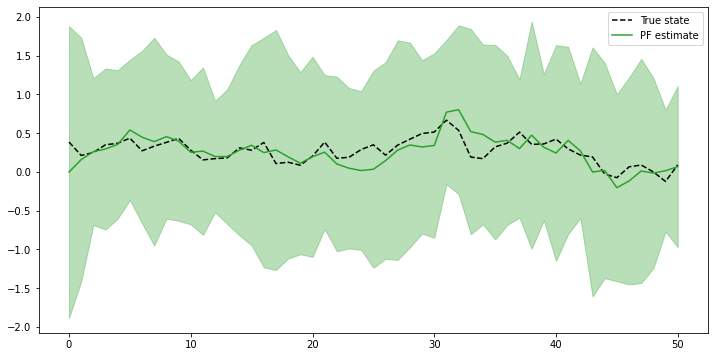

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
linspace = np.arange(T+1)
ax.plot(linspace, true_xs, color="k", linestyle="--", label="True state")
ax.plot(linspace, pf_ms, color="tab:green", label="PF estimate")

ax.fill_between(linspace,
        pf_ms - 1.96 * pf_Ps,
        pf_ms + 1.96 * pf_Ps,  
        color="tab:green", alpha=0.33)

_ = ax.legend()